## Смоделируем доходность портфеля из акций следующих компаний: Caterpillar, Intel, J.M. Smucker Comp., Tiffany & Co., Marathon Oil Corp.

In [236]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from datetime import datetime
#import yfinance as yf
import quandl as qdl
from arch import arch_model 

plt.style.use("bmh")

In [237]:
qdl.ApiConfig.api_key = 'heZWVP4ZBt-Cxestguui'
data = qdl.get_table('WIKI/PRICES', ticker = ['CAT', 'INTC', 'SJM', 'TIF', 'MRO'], 
                     qopts = { 'columns': ['ticker', 'date', 'close'] },
                     date = { 'gte': '2014-01-01', 'lte': '2019-11-20' },
                     paginate=True)
data = data.set_index('date')
data = data.pivot(columns='ticker')

prices = []

for ticker in data.columns.levels[0]:

    temp = data['close']
    temp.name = ticker
    prices.append(temp)

prices = pd.concat(prices, axis=1)

prices.head()

ticker,CAT,INTC,MRO,SJM,TIF
date,,,,,
2014-01-02,89.87,25.790,34.91,102.03,92.55
2014-01-03,89.82,25.780,34.52,101.51,92.28
2014-01-06,88.64,25.460,34.43,100.90,91.64
2014-01-07,88.93,25.585,34.88,101.52,92.15
2014-01-08,89.14,25.430,34.40,98.17,91.70


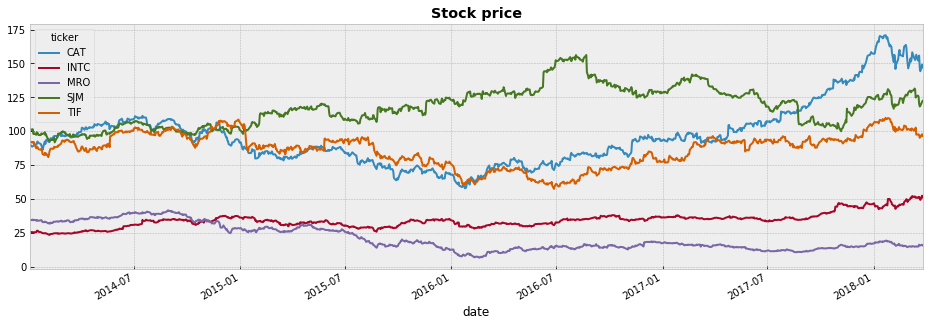

In [238]:
prices.plot(figsize=(16, 5))
plt.title("Stock price", weight="bold")
plt.show()

#### Акции рассматриваемых компаний вцелом а рассматриваемый период выросли. Значительных просдок не наблюдалось.
#### Ряд цен нестационарен. Перейдем от цен к доходностям, чтобы лучше определить характеристики временных рядов.

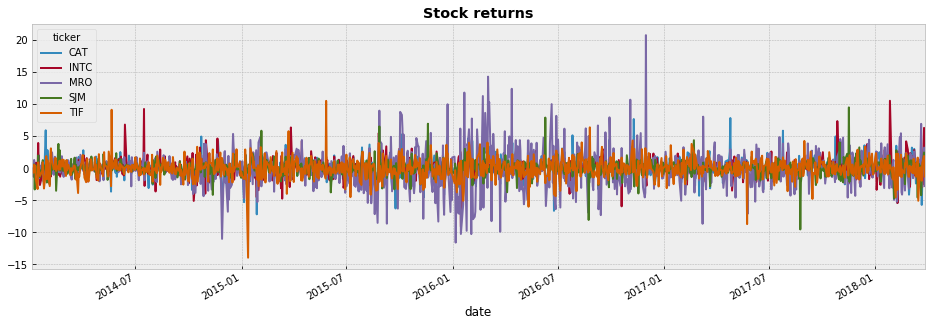

In [239]:
returns = 100*prices.pct_change().dropna()
returns.plot(figsize = (16,5))
plt.title('Stock returns', weight= 'bold')
plt.show()

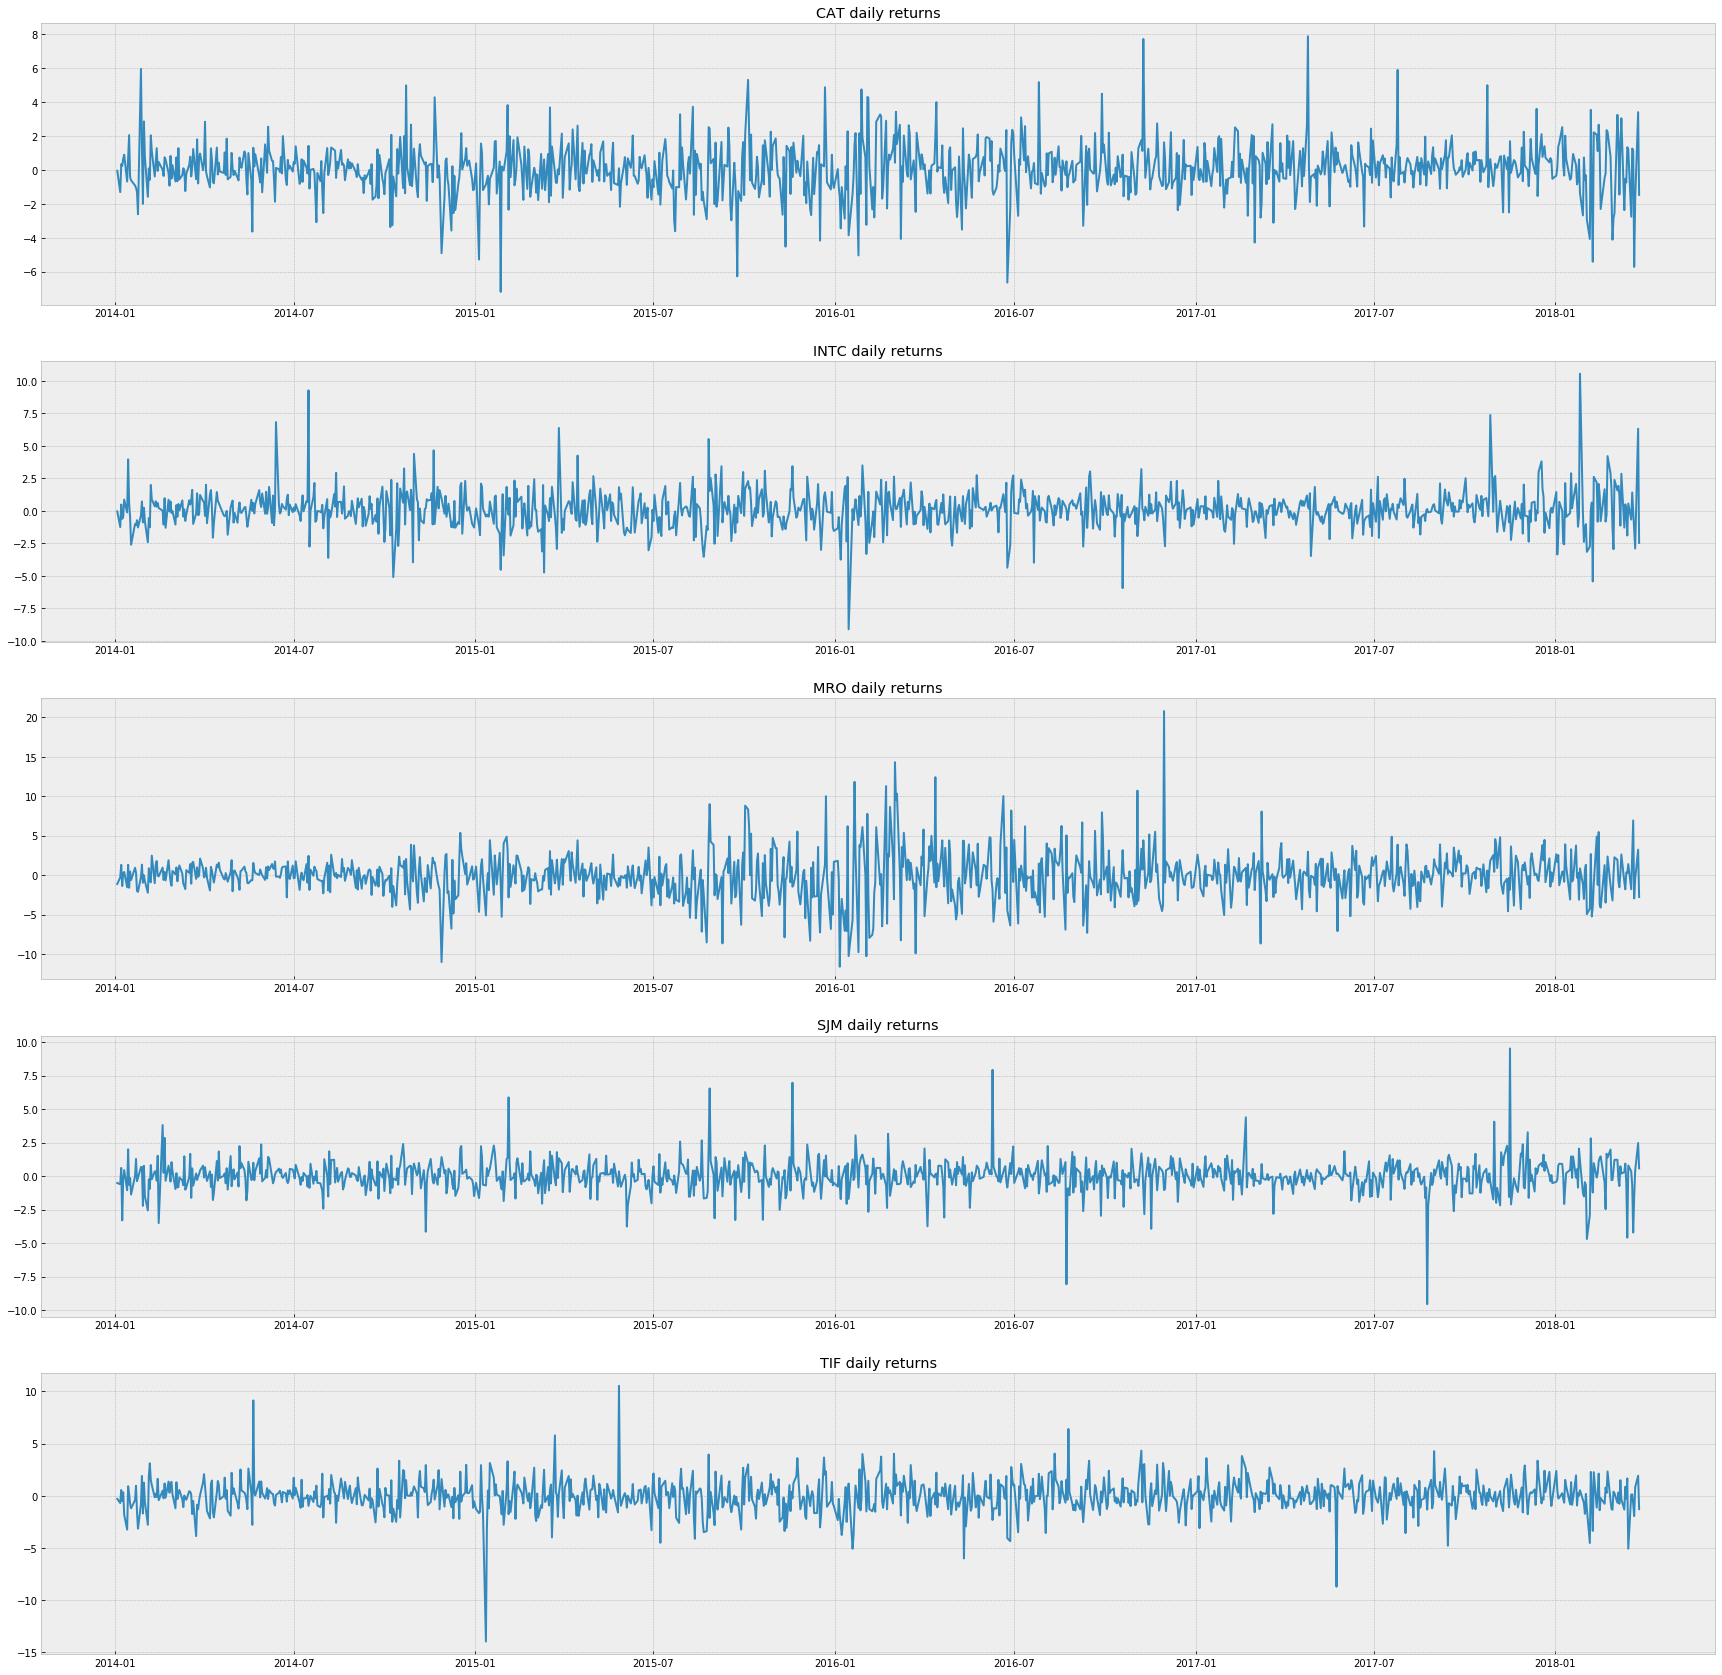

In [240]:
fig, axs = plt.subplots(5, 1, figsize=(30, 30))

axs[0].plot(returns['CAT'])
axs[0].set_title('CAT daily returns')
axs[1].plot(returns['INTC'])
axs[1].set_title('INTC daily returns')
axs[2].plot(returns['MRO'])
axs[2].set_title('MRO daily returns')
axs[3].plot(returns['SJM'])
axs[3].set_title('SJM daily returns')
axs[4].plot(returns['TIF'])
axs[4].set_title('TIF daily returns')
plt.show()

#### По графикам доходностей видно, что временные ряды стационарны. Однако присутствует кластеризация дисперсии, условное среднее во времени меняется. Амплитуда колебаний разнится - скорее всего ряды имеют мультипликативную структуру.

In [241]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [242]:
ret_cat = returns['CAT']
ret_intc = returns['INTC']
ret_mro = returns['MRO']
ret_sjm = returns['SJM']
ret_tif = returns['TIF']

#### Проанализируем АКФ и ЧАКФ доходностей рассматриваемых акций для определения оптимального числа лагов

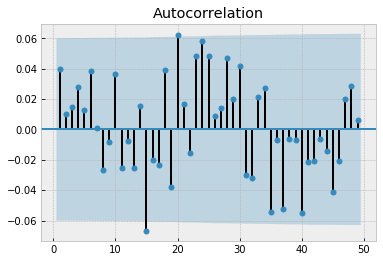

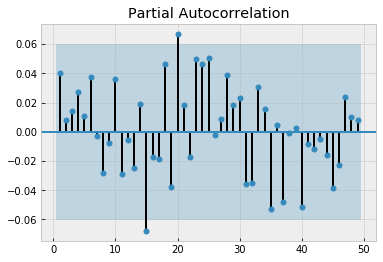

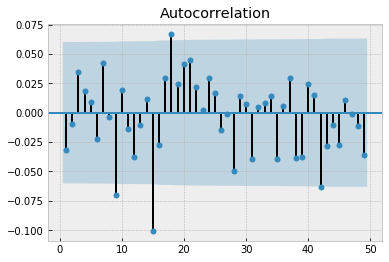

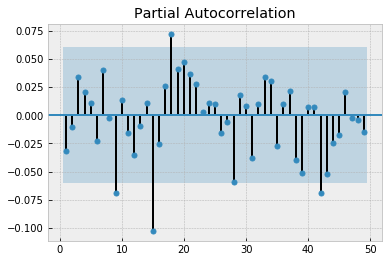

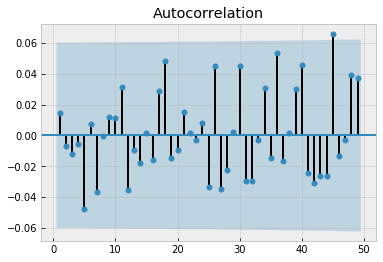

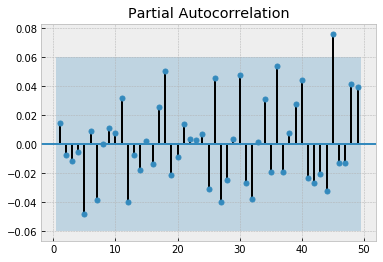

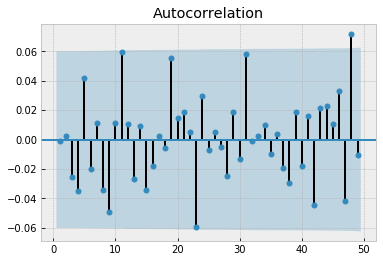

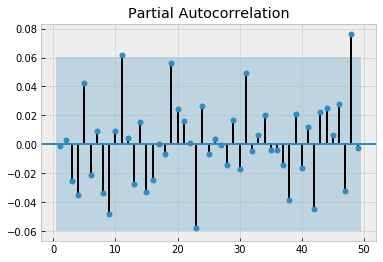

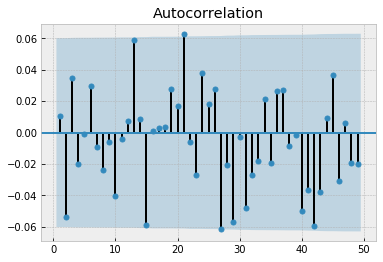

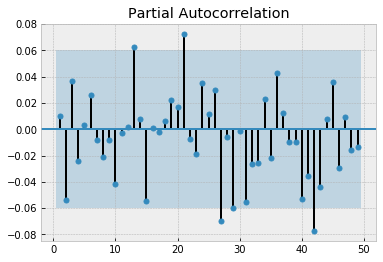

In [243]:
plot_acf(ret_mro, lags=np.arange(1, 50, 1))
plot_pacf(ret_mro, lags=np.arange(1, 50, 1))
plot_acf(ret_intc, lags=np.arange(1, 50, 1))
plot_pacf(ret_intc, lags=np.arange(1, 50, 1))
plot_acf(ret_cat, lags=np.arange(1, 50, 1))
plot_pacf(ret_cat, lags=np.arange(1, 50, 1))
plot_acf(ret_sjm, lags=np.arange(1, 50, 1))
plot_pacf(ret_sjm, lags=np.arange(1, 50, 1))
plot_acf(ret_tif, lags=np.arange(1, 50, 1))
plot_pacf(ret_tif, lags=np.arange(1, 50, 1))
plt.show()


 #### Видно, что в целом значения ряда некоррелированы. Присутствуют значимые коэффициенты АКФ и ЧАКФ на лагах высокого порядка (вплоть до 40). Поскольку мы анализируем ежедневные значения доходностей акций, смысл имеет брать лаги среднего порядка (не более 10). Оптимальным для подобных временных рядов считается порядок авторегрессии и скользящей средне равны пяти (временному ряду ежедневных доходностей не свойственна длинная или короткая память, скорее всего автокорреляция остатков будет наблюдаться в течение торговой недели (5 дней)

In [244]:
def kupiec_test(VaR_curve, actual_returns, pp=0.1):
    
    T = len(actual_returns)
    K = (actual_returns < VaR_curve).sum()
    alpha_0 = K / T
    
    S = -2*np.log((1-alpha)**(T-K) * alpha**K) + 2*np.log((1-alpha_0)**(T-K) * alpha_0**K)
    p_value = 1 - scipy.stats.chi2.cdf(S, df=1)
        
    if np.isnan(p_value):
        p_value = 0.
        
    print('Количество наблюдений:', T)
    print('Желаемый уровень пробитий: {:.1f}%'.format(alpha*100))
    print('Уровень пробитий в модели: {:.2f}%'.format(alpha_0*100))
        
    print('\np-value теста: {:.3f}'.format(p_value))
    if p_value > pp:
        print("""\nПри уровне значимости {:.0f}% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ""".format(pp*100))
    else:
        print("""\nПри уровне значимости {:.1f}% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается""".format(pp*100))

In [245]:
n_samples = 10 ** 5

return_simulations = {}

# для каждой акции оцениваем одномерное распределение, а потом сэмплируем из него новые псевдо-наблюдения
for col in returns.columns:
    t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
    return_simulations[col] = scipy.stats.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)
    
return_simulations = pd.DataFrame(return_simulations)

#### Рассмотрим ковариационную матрицу значений доходностей акций пяти рассматриваемых компаний. Видно, что вцело присутствует положительная ковариация доходностей - это объясняется тем, что все компании принадлежат к лидерам рынка в своих отраслях и показывают достаточную стабильность. Поэтому доходности компаний изменяются в одном направлении с рынком в целом. 

In [246]:
np.cov(returns.values, rowvar=False)

array([[2.31691196, 0.87453863, 2.21086009, 0.38786532, 0.91783754],
       [0.87453863, 2.13223723, 1.20675681, 0.51956945, 0.64178493],
       [2.21086009, 1.20675681, 8.46172774, 0.40470172, 1.35713739],
       [0.38786532, 0.51956945, 0.40470172, 1.49223939, 0.3057667 ],
       [0.91783754, 0.64178493, 1.35713739, 0.3057667 , 2.5025255 ]])

#### Ситуация отличается для сгенерированных доходностей. В целом видна обратная ковариация сэмплированных псевдо-доходностей

In [247]:
np.cov(return_simulations.values, rowvar=False)

array([[ 2.48096592e+00,  7.64416832e-02, -1.12370675e-02,
        -3.47384587e-04,  2.45536179e-02],
       [ 7.64416832e-02,  2.16396472e+00,  8.43230329e-03,
        -2.43203741e-03,  1.55279265e-02],
       [-1.12370675e-02,  8.43230329e-03,  1.08775213e+01,
         1.51622125e-01,  3.49531787e-02],
       [-3.47384587e-04, -2.43203741e-03,  1.51622125e-01,
         1.49817813e+00, -1.19848042e-02],
       [ 2.45536179e-02,  1.55279265e-02,  3.49531787e-02,
        -1.19848042e-02,  2.45089315e+00]])

In [248]:
from copulae import NormalCopula, GaussianCopula, StudentCopulaб ClaytonCopula, FrankCopula, GumbelCopula, EmpiricalCopula

#### Оценим параметры распределений доходностей акций рассматриваемых компаний

In [249]:
cdfs = returns.copy()
distribution_params = {}

for col in cdfs.columns:
    t_df, t_mean, t_sigma = scipy.stats.t.fit(cdfs[col])
    distribution_params[col] = (t_df, t_mean, t_sigma)
    cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

In [250]:
distribution_params

{'CAT': (3.757936675457271, 0.05322946821223634, 1.0779518711827152),
 'INTC': (3.5995367570677406, 0.06266349384305975, 0.9877821036200125),
 'MRO': (2.985499762346794, -0.03634003028266619, 1.8536796109307805),
 'SJM': (3.1963866656250235, 0.032789568232535475, 0.7512971794083179),
 'TIF': (4.257010227358553, 0.02413814509382107, 1.1347932057549197)}

In [251]:
from copulae.gof import rad_sym_test
test_stats = rad_sym_test(returns)
print(test_stats.p_value)

0.004495504495504496


###### Маленькое р-значение свидетельствует об отсутствии радиальной симметрии. Следовательно, необходимо использовать копулы, отличные от эллиптических. В данном примере будем перебирать копулы из симейства Архимедовых

In [252]:
cop = ClaytonCopula(dim=5)
cop.fit(cdfs)

In [253]:
cop.summary()

clayton Copula Summary
================================================================================
clayton Copula with 5 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 0.3622476329806582



                                  Fit Summary                                   
================================================================================
Log. Likelihood      : -327.5691747670353
Variance Estimate    : Not Implemented Yet
Method               : Maximum pseudo-likelihood
Data Points          : 1064

Optimization Setup
--------------------------------------------------------------------------------
	bounds         : [(0, inf)]
	options        : {'maxiter': 20000, 'ftol': 1e-06, 'iprint': 1, 'disp': False, 'eps': 1.5e-08}
	method         : SLSQP

Results
--------------------------------------------------------------------------------
	x              : [0.36224763]
	fun            : -327.5691747670353
	jac            : [0.00734417]
	nit            : 5
	nfev           : 16
	njev           : 5
	status         : 0
	message        : Optimization terminated successfully.
	success        : True

In [254]:
cop = FrankCopula(dim=5)
cop.fit(cdfs)

In [255]:
cop.summary()


frank Copula Summary
================================================================================
frank Copula with 5 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 1.8312360908111542



                                  Fit Summary                                   
================================================================================
Log. Likelihood      : -334.77230290476996
Variance Estimate    : Not Implemented Yet
Method               : Maximum pseudo-likelihood
Data Points          : 1064

Optimization Setup
--------------------------------------------------------------------------------
	bounds         : [(0, inf)]
	options        : {'maxiter': 20000, 'ftol': 1e-06, 'iprint': 1, 'disp': False, 'eps': 1.5e-08}
	method         : SLSQP

Results
--------------------------------------------------------------------------------
	x              : [1.83123609]
	fun            : -334.77230290476996
	jac            : [0.00286491]
	nit            : 4
	nfev           : 13
	njev           : 4
	status         : 0
	message        : Optimization terminated successfully.
	success        : True

In [256]:
cop = GumbelCopula(dim=5)
cop.fit(cdfs)
cop.summary()

gumbel Copula Summary
================================================================================
gumbel Copula with 5 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 1.2324842141100352



                                  Fit Summary                                   
================================================================================
Log. Likelihood      : -317.8590867152031
Variance Estimate    : Not Implemented Yet
Method               : Maximum pseudo-likelihood
Data Points          : 1064

Optimization Setup
--------------------------------------------------------------------------------
	bounds         : [(1.0, inf)]
	options        : {'maxiter': 20000, 'ftol': 1e-06, 'iprint': 1, 'disp': False, 'eps': 1.5e-08}
	method         : SLSQP

Results
--------------------------------------------------------------------------------
	x              : [1.23248421]
	fun            : -317.8590867152031
	jac            : [0.01327483]
	nit            : 5
	nfev           : 16
	njev           : 5
	status         : 0
	message        : Optimization terminated successfully.
	success        : True

#### Копула Гумбеля показала нименьшее значение целевой функции (Log likelihood). Скорее всего данный тип копулы подходит нам больше всего. Проверим эту гипотезу с помощью бэк-теста

In [257]:
univariate_dist = 'gennorm' # gennorm
cop = GumbelCopula(dim=cdfs.shape[1])
n_samples = 10 ** 5

cdfs = returns.copy()
distribution_params = {}

for col in cdfs.columns:
    if univariate_dist == 't':
        t_df, t_mean, t_sigma = scipy.stats.t.fit(cdfs[col])
        distribution_params[col] = (t_df, t_mean, t_sigma)
        cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)
    else:
        beta, loc, scale = scipy.stats.gennorm.fit(cdfs[col])
        distribution_params[col] = (beta, loc, scale)
        cdfs[col] = scipy.stats.gennorm.cdf(cdfs[col], beta, loc, scale)

cop.fit(cdfs)

copula_simulations = cop.random(n_samples, seed=42)
copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

return_simulations = copula_simulations.copy()

for col in cdfs.columns:
    if univariate_dist == 't':
        t_df, t_mean, t_sigma = distribution_params[col]
        return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)
    else:
        beta, loc, scale = distribution_params[col]
        return_simulations[col] = scipy.stats.gennorm.ppf(copula_simulations[col], beta, loc, scale)

In [258]:
from arch import arch_model 

In [259]:
def get_garch_residuals(ret, dist):

    # объявляем GARCH модель
    am = arch_model(ret,
                    mean=mean, lags=lags, # mean = Constant, ARX, HARX + the number of lags
                    vol=vol, p=p, o=o, q=q1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    # фитим модель на данных
    res = am.fit(update_freq=1, disp='off')

    # сохраняем ее распределение
    if dist == 'Normal':
        cdf = am.distribution.cdf(res.resid.dropna())
    elif dist == 't' or dist == 'ged':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-1:])
    elif dist == 'skewstudent':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-2:])
        
    return cdf, am, res


def make_garch_forecast(copula_simulation, dist, garch_object, garch_model):
    
    # делаем прогноз среднего и дисперсии
    forecasts = garch_object.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # получаем из сэплов квантили сэмплы доходностей
    if dist == 'Normal':
        q = garch_model.distribution.ppf(copula_simulation)
    elif dist == 't' or dist == 'ged':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-1:])
    elif dist == 'skewstudent':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-2:])

    # и по формуле считаем ВаР
    return cond_mean + np.sqrt(cond_var) * q

In [260]:
def make_copula_simulation(returns, copula_func, n_samples, univariate_dist, dist='skewstudent'):

    # объявляем копулу
    cop = copula_func(dim=returns.shape[1])

    cdfs = returns.copy()
    distribution_params = {}

    # моделируем частные распределения для каждой акции
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
            distribution_params[col] = (t_df, t_mean, t_sigma)
            cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = scipy.stats.gennorm.fit(returns[col])
            distribution_params[col] = (beta, loc, scale)
            cdfs[col] = scipy.stats.gennorm.cdf(cdfs[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            cdf, am, res = get_garch_residuals(returns[col], dist)
            distribution_params[col] = (am, res)
            cdfs[col] = cdf

    # фитим копулу
    cop.fit(cdfs)

    # делаем сэмплирование квантилей из совместного распределения копулы
    copula_simulations = cop.random(n_samples, seed=42)
    copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

    return_simulations = copula_simulations.copy()

    # трансформируем квантили в доходности с помощью частных функций распределений из первого шага
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = distribution_params[col]
            return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = distribution_params[col]
            return_simulations[col] = scipy.stats.gennorm.ppf(copula_simulations[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            am, res = distribution_params[col]
            return_simulations[col] = make_garch_forecast(copula_simulations[col], dist, res, am)
            
    # возвращаем матрицу сэмплированных доходностей
    return return_simulations

#### Приведенные ниже параметры получены после нескольких итераций как наиболее оптимальные. Параметры модели GARCH(1,0,1) также подтверждают теорию о наибольшей эффективности данной модели при моделировании финансовых показателей. 
#### Также выбор модели FIGARCH в качестве наиболее оптимальной подтверждает ее высокое качество при моделировании волатильности временных рядов с длинной памятью

In [269]:
mean = 'ARX'
ret = returns
dist = 'skewstudent'
lags = np.arange(1,5,1)
p = 1
o = 0
q1 = 1
vol = 'FIGARCH'

In [270]:
return_simulations_clayton = make_copula_simulation(returns, ClaytonCopula, n_samples=10**5, univariate_dist='garch')

In [271]:
return_simulations_gumbel = make_copula_simulation(returns, GumbelCopula, n_samples=10**5, univariate_dist='garch')

In [272]:
return_simulations_frank = make_copula_simulation(returns, FrankCopula, n_samples=10**5, univariate_dist='garch')

#### Посмотрим на значения квантилей для различных копул и для действительных значений доходностей

In [273]:
alpha = 0.05

w = np.ones(shape=(returns.shape[1],)) / 5

portfolio_real_returns = np.dot(returns.values, w)
portfolio_simulated_returns_clayton = np.dot(return_simulations_clayton.values, w)
portfolio_simulated_returns_gumbel = np.dot(return_simulations_gumbel.values, w)
portfolio_simulated_returns_frank = np.dot(return_simulations_frank.values, w)

print('Q for real returns: ', np.quantile(portfolio_real_returns, alpha))
print('Q for Clayton Copula: ', np.quantile(portfolio_simulated_returns_clayton, alpha))
print('Q for Gumbel Copula: ', np.quantile(portfolio_simulated_returns_gumbel, alpha))
print('Q for Frank Copula: ', np.quantile(portfolio_simulated_returns_frank, alpha))

Q for real returns:  -1.851225777521638
Q for Clayton Copula:  -2.2649681454449704
Q for Gumbel Copula:  -2.029804679692852
Q for Frank Copula:  nan


#### Проведем бэк-тест

In [274]:
def make_dummy_student_simulations(returns, n_samples):
    
    return_simulations = {}
    for col in returns.columns:
        t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
        return_simulations[col] = scipy.stats.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)

    return_simulations = pd.DataFrame(return_simulations)

    return return_simulations


def make_mult_normal_simulations(returns, n_samples):

    mean = np.mean(returns.values, axis=0)
    cov = np.cov(returns.values, rowvar=False)

    return_simulations = scipy.stats.multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples, random_state=42)

    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

    return return_simulations

In [275]:
alpha = 0.05

w = np.ones(shape=(returns.shape[1],)) / 5

# определяем параметры бэктеста
T = len(ret)
T_start = 100
estimation_window = 500
testing_window = T - estimation_window

VaR_curve_HS = []
VaR_curve_student = []
VaR_curve_multivariate_normal = []
VaR_curve_clayton_t = []
VaR_curve_clayton_garch = []
VaR_curve_gumbel_t = []
VaR_curve_gumbel_garch = []
# в цикле проходимся по всем дням в выборке
for t in range(estimation_window+T_start, T):
    
    # фиксируем часть выборки
    current_estimation_sample = returns[t-estimation_window:t]
    
    # различными способами оцениваем ВаР и сохраняем значения
    protfolio = np.dot(current_estimation_sample.values, w)
    VaR_curve_HS.append(np.quantile(protfolio, alpha))
    
    student_simulation = make_dummy_student_simulations(current_estimation_sample, 10**4)
    VaR_curve_student.append(np.quantile(np.dot(student_simulation.values, w), alpha))
    
    multivariate_normal_simulation = make_mult_normal_simulations(current_estimation_sample, 10**4)
    VaR_curve_multivariate_normal.append(np.quantile(np.dot(multivariate_normal_simulation.values, w), alpha))
    
    clayton_t_simulation = make_copula_simulation(current_estimation_sample, ClaytonCopula, n_samples=10**4,
                                                 univariate_dist='t')
    VaR_curve_clayton_t.append(np.quantile(np.dot(clayton_t_simulation.values, w), alpha))
    
    clayton_garch_simulation = make_copula_simulation(current_estimation_sample, ClaytonCopula,
                                                     n_samples=10**4, univariate_dist='garch')
    VaR_curve_clayton_garch.append(np.quantile(np.dot(clayton_garch_simulation.values, w), alpha))
    ###
    
    gumbel_t_simulation = make_copula_simulation(current_estimation_sample, GumbelCopula, n_samples=10**4,
                                                 univariate_dist='t')
    VaR_curve_gumbel_t.append(np.quantile(np.dot(gumbel_t_simulation.values, w), alpha))
    
    gumbel_garch_simulation = make_copula_simulation(current_estimation_sample, GumbelCopula,
                                                     n_samples=10**4, univariate_dist='garch')
    VaR_curve_gumbel_garch.append(np.quantile(np.dot(gumbel_garch_simulation.values, w), alpha))
    
    
VaR_curve_HS = pd.Series(VaR_curve_HS, index=ret[estimation_window+T_start:].index)
VaR_curve_student = pd.Series(VaR_curve_student, index=ret[estimation_window+T_start:].index)
VaR_curve_multivariate_normal = pd.Series(VaR_curve_multivariate_normal, index=ret[estimation_window+T_start:].index)

VaR_curve_clayton_t = pd.Series(VaR_curve_clayton_t, index=ret[estimation_window+T_start:].index)
VaR_curve_clayton_garch = pd.Series(VaR_curve_clayton_garch, index=ret[estimation_window+T_start:].index)

VaR_curve_gumbel_t = pd.Series(VaR_curve_gumbel_t, index=ret[estimation_window+T_start:].index)
VaR_curve_gumbel_garch = pd.Series(VaR_curve_gumbel_garch, index=ret[estimation_window+T_start:].index)


portfolio = np.dot(returns[estimation_window+T_start:].values, w)
portfolio = pd.Series(portfolio, index=ret[estimation_window+T_start:].index)

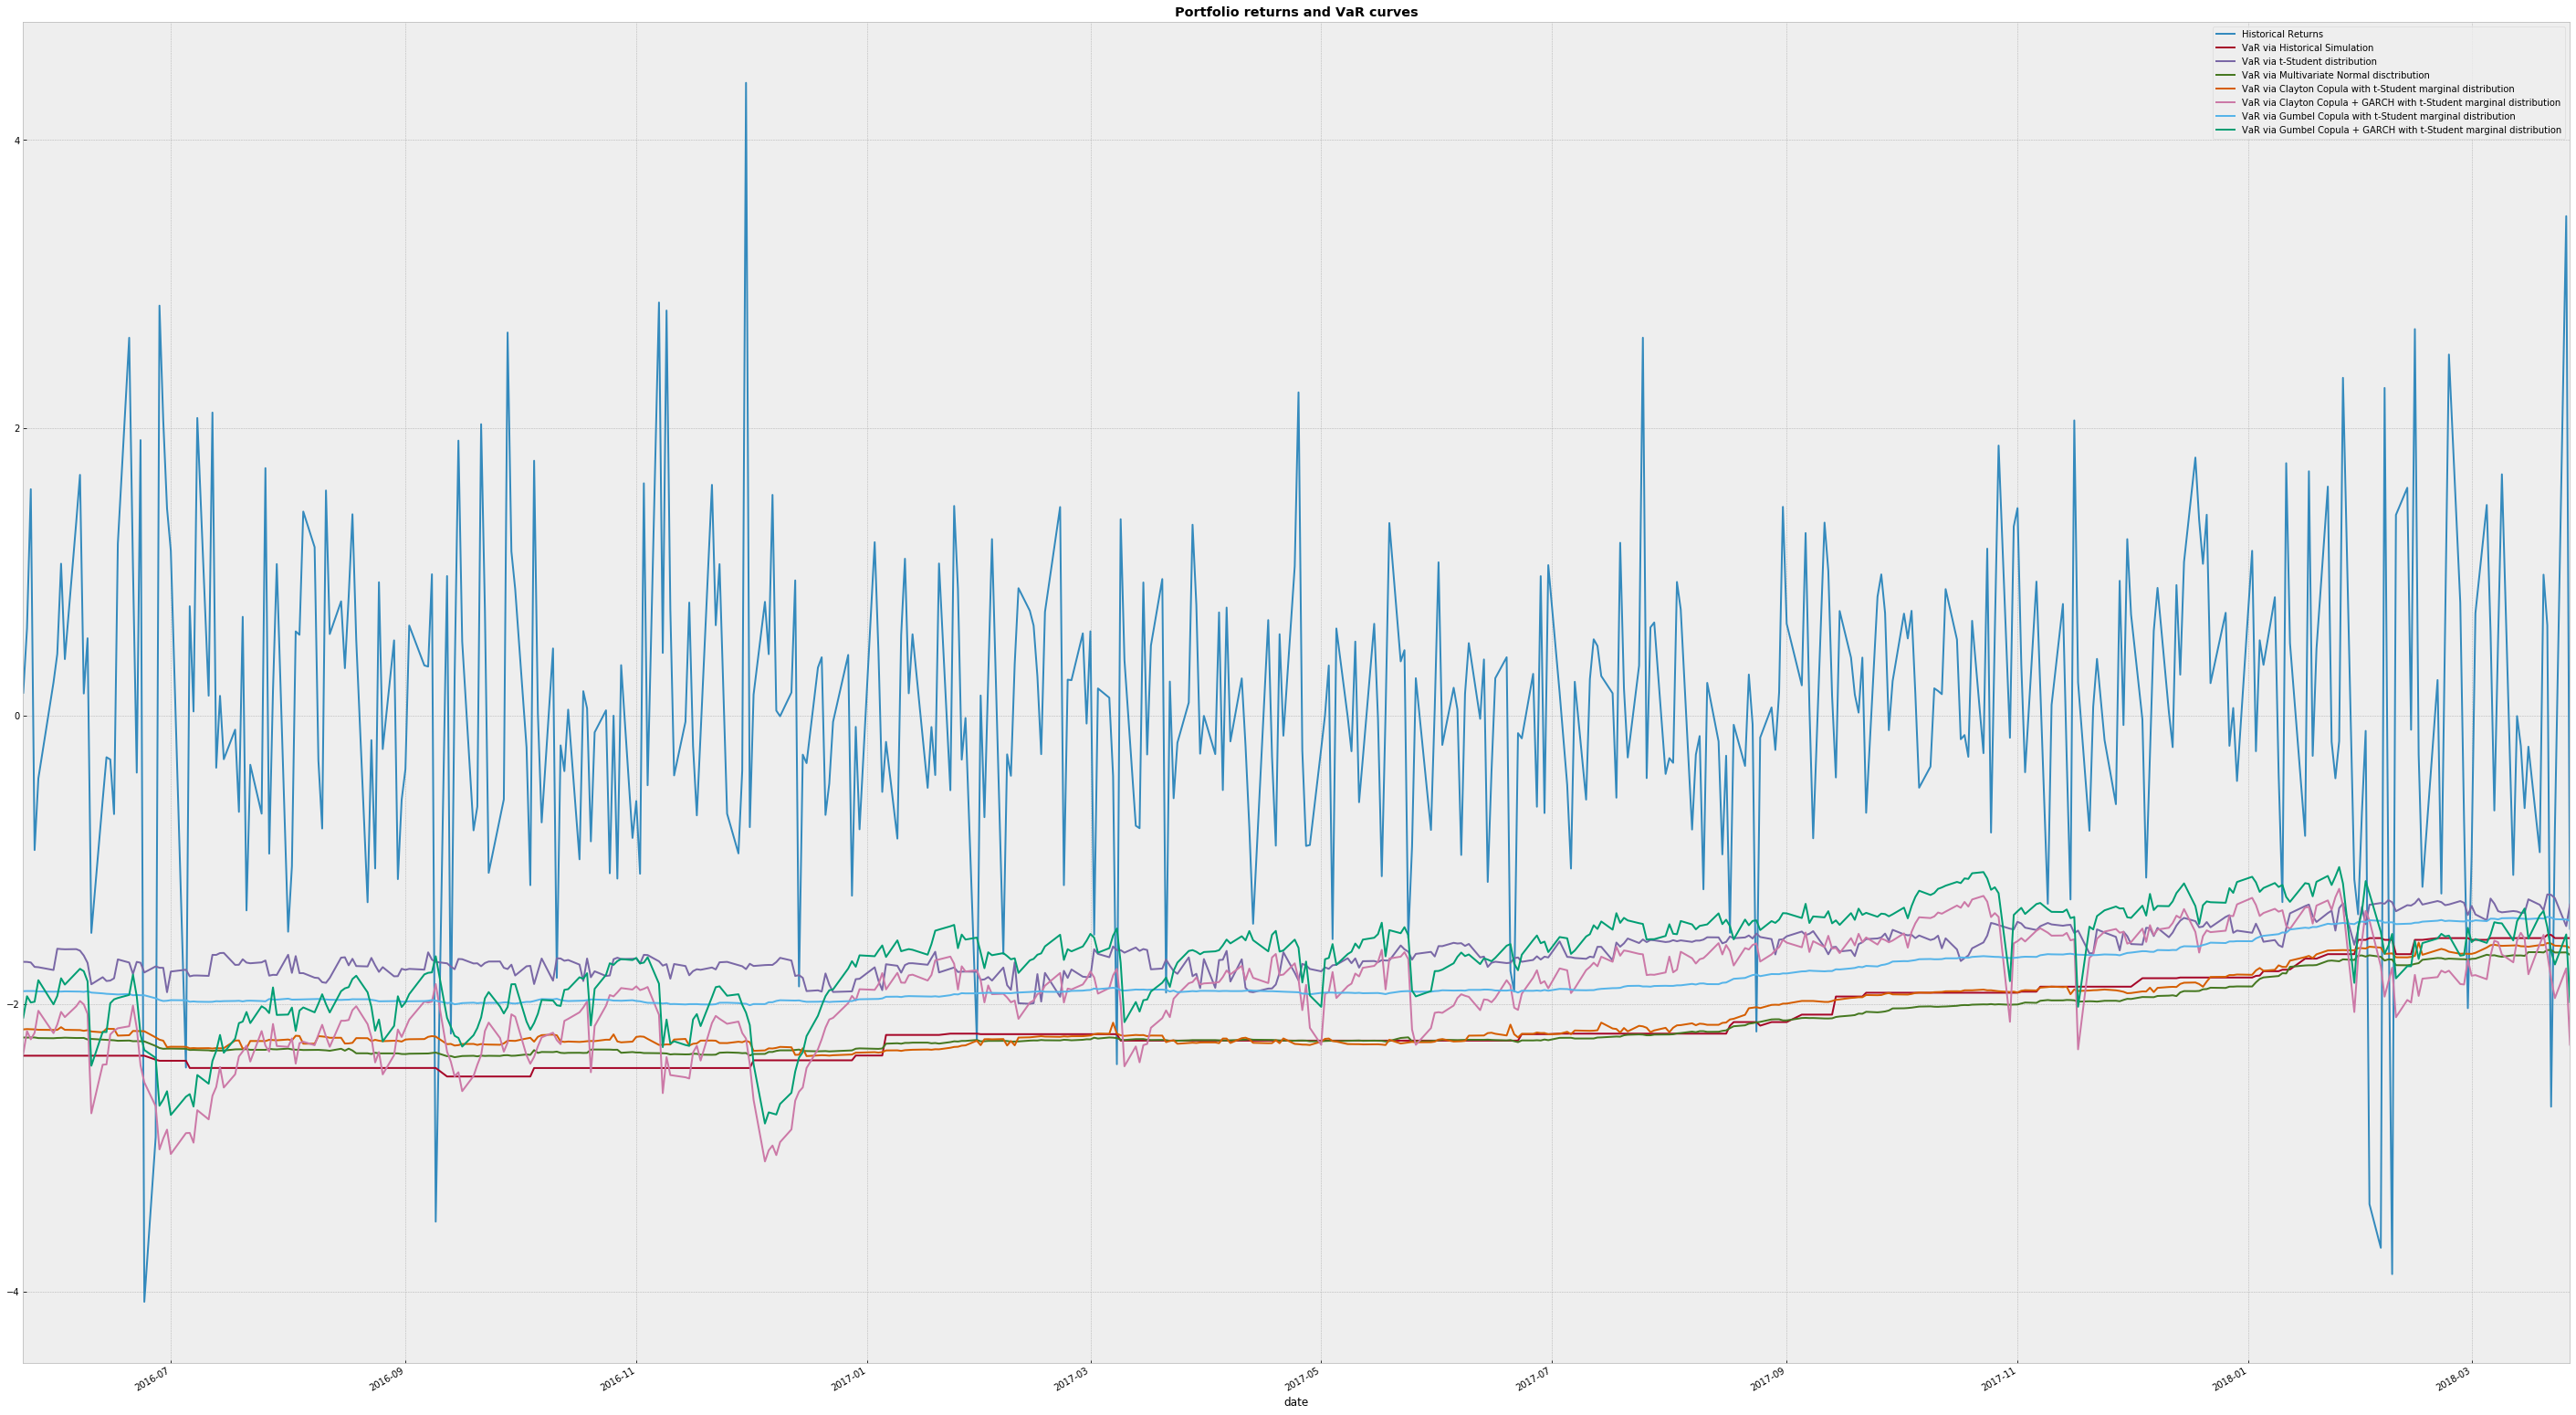

In [276]:
fig = plt.figure()
fig.set_size_inches(50,30)
portfolio.plot()
VaR_curve_HS.plot()
VaR_curve_student.plot()
VaR_curve_multivariate_normal.plot()
VaR_curve_clayton_t.plot()
VaR_curve_clayton_garch.plot()
VaR_curve_gumbel_t.plot()
VaR_curve_gumbel_garch.plot()

plt.title("Portfolio returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
            'VaR via t-Student distribution',
            'VaR via Multivariate Normal disctribution',
            'VaR via Clayton Copula with t-Student marginal distribution',
           'VaR via Clayton Copula + GARCH with t-Student marginal distribution',
           'VaR via Gumbel Copula with t-Student marginal distribution',
           'VaR via Gumbel Copula + GARCH with t-Student marginal distribution'])

#### Проведем тест Купика для различных спецификаций модели  и определим лучшую

In [277]:
kupiec_test(VaR_curve_HS, portfolio)

Количество наблюдений: 464
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 2.59%

p-value теста: 0.009

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [278]:
kupiec_test(VaR_curve_student, portfolio)

Количество наблюдений: 464
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 4.09%

p-value теста: 0.356

При уровне значимости 10% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ


In [279]:
kupiec_test(VaR_curve_multivariate_normal, portfolio)

Количество наблюдений: 464
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 2.37%

p-value теста: 0.004

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [280]:
kupiec_test(VaR_curve_clayton_t, portfolio)

Количество наблюдений: 464
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 2.37%

p-value теста: 0.004

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [281]:
kupiec_test(VaR_curve_clayton_garch, portfolio)

Количество наблюдений: 464
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 2.37%

p-value теста: 0.004

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [282]:
kupiec_test(VaR_curve_gumbel_t, portfolio)

Количество наблюдений: 464
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 3.45%

p-value теста: 0.105

При уровне значимости 10% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ


In [283]:
kupiec_test(VaR_curve_gumbel_garch, portfolio)

Количество наблюдений: 464
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 4.09%

p-value теста: 0.356

При уровне значимости 10% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ


#### Лучшее качество показала модель с использованием копулы Гумбеля и и модели GARCH. Хорошее качество также показала модель Gumbel-Skewed_Student, однако р-значения для данной спецификации значительно меньше и находится на границе области принятия гипотезы (при даже незначительном изменении структуры временного ряда она может попасть в область отвержения гипотезы). 
#### Срвнимые значения показала модель VAR-curve - t-Student, однако она не учитывает памяти временного ряда


#### Теперь, когда мы выбрали наилучшую модель, подберем веса портфеля с использованием различных целевых функций
#### Сначала подберем веса для портфеля со стратегией buy-hold

In [358]:
from scipy.optimize import minimize

# объявляем целевую функцию, которую мы будем минимизировать (поэтому в нужных местах ставим минусы)
def calculate_objective_function(weights, returns_simulation, alpha, objective_type):
    
    portfolio_simulation = np.dot(returns_simulation.values, weights)
    
    if objective_type == 'return':
        return np.mean(portfolio_simulation)
    
    elif objective_type == 'var':
        return -np.quantile(portfolio_simulation, alpha)
    
    elif objective_type == 'exp_shortfall':
        return -portfolio_simulation[portfolio_simulation<(np.quantile(portfolio_simulation, alpha))].mean()
    #np.mean(-np.quantile(portfolio_simulation, alpha))
    
    elif objective_type == 'exp_success':
        return portfolio_simulation[portfolio_simulation>(np.quantile(portfolio_simulation, (1-alpha)))].mean()
    #np.mean(np.quantile(portfolio_simulation, (1-alpha)))
    
    elif objective_type == 'rachev':
        return portfolio_simulation[portfolio_simulation<(np.quantile(portfolio_simulation, (1-alpha)))].mean()/ portfolio_simulation[portfolio_simulation<(np.quantile(portfolio_simulation, alpha))].mean()
    
    elif objective_type == 'sharpe':
        return pd.DataFrame(portfolio_simulation).pct_change(1).mean()/pd.DataFrame(portfolio_simulation).std()
    
    
def optimize(returns_simulation, alpha=0.01, objective_type='var'):
        
    init_guess = np.ones(shape=(returns.shape[1],)) / returns.shape[1]
    
    # вот тут можно поставить другие ограничения, например от -1 до 1, чтобы появилась возможность шортить -- продавать
    #какие-то акции
    bounds = ((0.0, 1.0),) * returns.shape[1]
    
    weights = minimize(calculate_objective_function, init_guess,
                       args=(returns_simulation,alpha,objective_type), method='SLSQP',
                       options={'disp': False},
                       constraints=({'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)}),
                       bounds=bounds)
    
    return weights.x

In [359]:
alpha = 0.01

w = np.ones(shape=(returns.shape[1],)) / 5

T = len(ret)
T_start = 100
estimation_window = 250
testing_window = T - estimation_window

value = 100

value_const_weights = [value]
value_opt_weights_return = [value]
value_opt_weights_var = [value]
value_opt_weights_exp_shortfall = [value]
value_opt_weights_exp_success = [value]
value_opt_weights_rachev = [value]
value_opt_weights_sharpe = [value]

# делаем почти то же самое, что и в бэктесте ВаР
for t in range(estimation_window+T_start, T):
    
    real_returns = returns.iloc[t].values / 100
    
    value_new = np.dot(1+real_returns, w) * value_const_weights[-1]
    value_const_weights.append(value_new)
    
    # фиксируем тренировочное окно и делаем сэмплы
    current_estimation_sample = returns[t-estimation_window:t]
    copula_garch_simulation = make_copula_simulation(current_estimation_sample, GumbelCopula, n_samples=10**4,
                                                     univariate_dist='garch')
    
    # и различными способами оптимизируем веса в портфеле
    w_opt = optimize(copula_garch_t_simulation, objective_type='return')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_return[-1]
    value_opt_weights_return.append(value_new)
    
    w_opt = optimize(copula_garch_t_simulation, objective_type='var')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_var[-1]
    value_opt_weights_var.append(value_new)
    
    w_opt = optimize(copula_garch_t_simulation, objective_type='exp_shortfall')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_exp_shortfall[-1]
    value_opt_weights_exp_shortfall.append(value_new)
    
    w_opt = optimize(copula_garch_t_simulation, objective_type='exp_success')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_exp_success[-1]
    value_opt_weights_exp_success.append(value_new)
    
    w_opt = optimize(copula_garch_t_simulation, objective_type='rachev')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_rachev[-1]
    value_opt_weights_rachev.append(value_new)
    
    w_opt = optimize(copula_garch_t_simulation, objective_type='sharpe')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_sharpe[-1]
    value_opt_weights_sharpe.append(value_new)
    
value_const_weights.pop(0)
value_opt_weights_return.pop(0)
value_opt_weights_var.pop(0)
value_opt_weights_exp_success.pop(0)
value_opt_weights_exp_shortfall.pop(0)
value_opt_weights_rachev.pop(0)
value_opt_weights_sharpe.pop(0)

value_const_weights = pd.Series(value_const_weights, index=ret[estimation_window+T_start:].index)
value_opt_weights_return = pd.Series(value_opt_weights_return, index=ret[estimation_window+T_start:].index)
value_opt_weights_var = pd.Series(value_opt_weights_var, index=ret[estimation_window+T_start:].index)
value_opt_weights_exp_shortfall = pd.Series(value_opt_weights_exp_shortfall, index=ret[estimation_window+T_start:].index)
value_opt_weights_exp_success = pd.Series(value_opt_weights_exp_success, index=ret[estimation_window+T_start:].index)
value_opt_weights_rachev = pd.Series(value_opt_weights_rachev, index=ret[estimation_window+T_start:].index)
value_opt_weights_sharpe = pd.Series(value_opt_weights_sharpe, index=ret[estimation_window+T_start:].index)

C:\Users\Asus\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9373. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9377. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScale

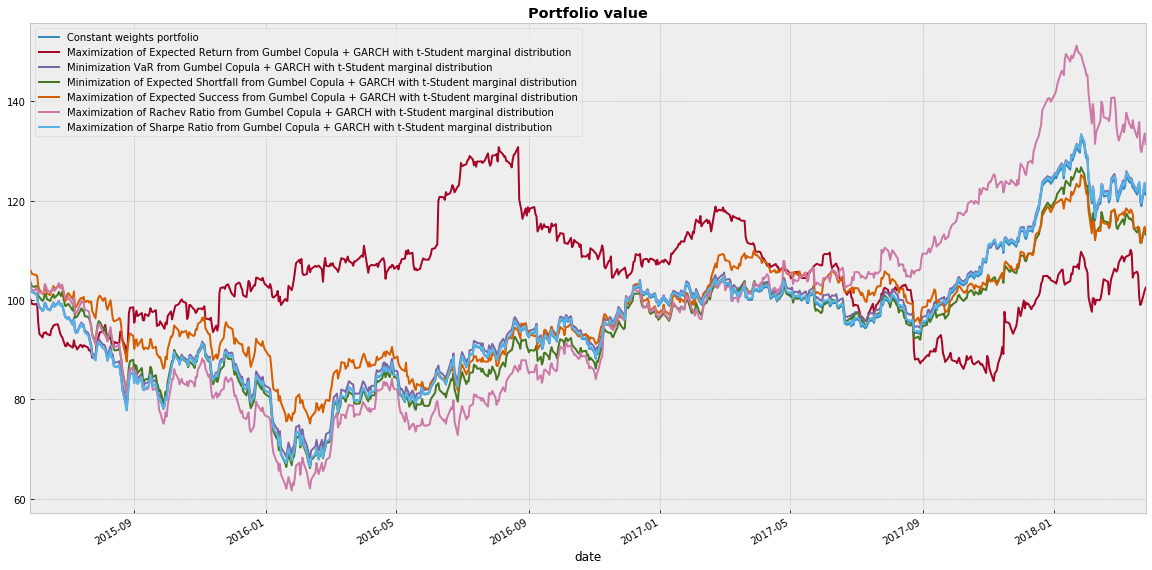

In [360]:
fig = plt.figure()
fig.set_size_inches(20,10)
value_const_weights.plot()
value_opt_weights_return.plot()
value_opt_weights_var.plot()
value_opt_weights_exp_shortfall.plot()
value_opt_weights_exp_success.plot()
value_opt_weights_rachev.plot()
value_opt_weights_sharpe.plot()

plt.title("Portfolio value", weight="bold")

plt.legend(['Constant weights portfolio',
            'Maximization of Expected Return from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Minimization VaR from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Minimization of Expected Shortfall from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Maximization of Expected Success from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Maximization of Rachev Ratio from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Maximization of Sharpe Ratio from Gumbel Copula + GARCH with t-Student marginal distribution'
           ])

#### Как видно, наибольшую доходность показала оптимизация весов при максимизации Expected Return, однако она же и показала наибольший "провал" при изменении общего тренда. Максимизация Rachev Ratio показала наименьшие результаты в начале, однако в конце с ростом волатильности она выиграла.  
#### Лучше всего себя показали модели с оптимизацией VAR и Sharpe Ratio.
#### Рассмотрим детальнее последний участок графика доходностей портфеля

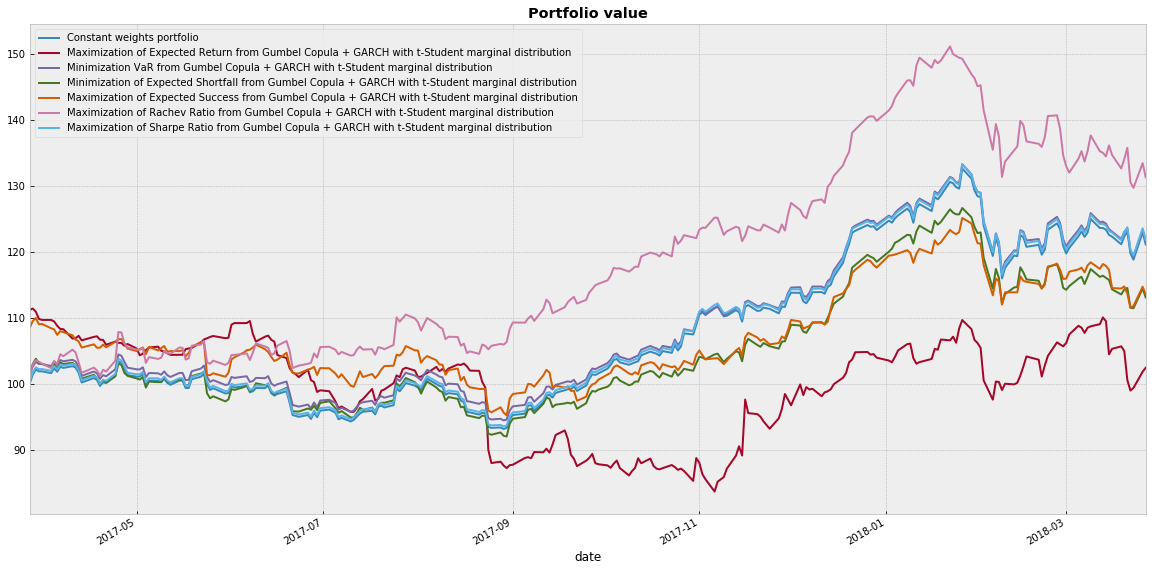

In [361]:
fig = plt.figure()
fig.set_size_inches(20,10)
value_const_weights['2017.03.27':'2018.03.27'].plot()
(value_opt_weights_return['2017.03.27':'2018.03.27']).plot()
value_opt_weights_var['2017.03.27':'2018.03.27'].plot()
value_opt_weights_exp_shortfall['2017.03.27':'2018.03.27'].plot()
value_opt_weights_exp_success['2017.03.27':'2018.03.27'].plot()
value_opt_weights_rachev['2017.03.27':'2018.03.27'].plot()
value_opt_weights_sharpe['2017.03.27':'2018.03.27'].plot()

plt.title("Portfolio value", weight="bold")

plt.legend(['Constant weights portfolio',
            'Maximization of Expected Return from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Minimization VaR from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Minimization of Expected Shortfall from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Maximization of Expected Success from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Maximization of Rachev Ratio from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Maximization of Sharpe Ratio from Gumbel Copula + GARCH with t-Student marginal distribution'
           ])
plt.show()

#### Добавим возможность шортить и сравним результаты

In [363]:
def optimize(returns_simulation, alpha=0.01, objective_type='var'):
        
    init_guess = np.ones(shape=(returns.shape[1],)) / returns.shape[1]
    
    # вот тут можно поставить другие ограничения, например от -1 до 1, чтобы появилась возможность шортить -- продавать
    #какие-то акции
    bounds = ((-1.0, 1.0),) * returns.shape[1]
    
    weights = minimize(calculate_objective_function, init_guess,
                       args=(returns_simulation,alpha,objective_type), method='SLSQP',
                       options={'disp': False},
                       constraints=({'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)}),
                       bounds=bounds)
    
    return weights.x

In [364]:
alpha = 0.01

w = np.ones(shape=(returns.shape[1],)) / 5

T = len(ret)
T_start = 100
estimation_window = 250
testing_window = T - estimation_window

value = 100

value_const_weights = [value]
value_opt_weights_return = [value]
value_opt_weights_var = [value]
value_opt_weights_exp_shortfall = [value]
value_opt_weights_exp_success = [value]
value_opt_weights_rachev = [value]
value_opt_weights_sharpe = [value]

# делаем почти то же самое, что и в бэктесте ВаР
for t in range(estimation_window+T_start, T):
    
    real_returns = returns.iloc[t].values / 100
    
    value_new = np.dot(1+real_returns, w) * value_const_weights[-1]
    value_const_weights.append(value_new)
    
    # фиксируем тренировочное окно и делаем сэмплы
    current_estimation_sample = returns[t-estimation_window:t]
    copula_garch_simulation = make_copula_simulation(current_estimation_sample, GumbelCopula, n_samples=10**4,
                                                     univariate_dist='garch')
    
    # и различными способами оптимизируем веса в портфеле
    w_opt = optimize(copula_garch_t_simulation, objective_type='return')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_return[-1]
    value_opt_weights_return.append(value_new)
    
    w_opt = optimize(copula_garch_t_simulation, objective_type='var')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_var[-1]
    value_opt_weights_var.append(value_new)
    
    w_opt = optimize(copula_garch_t_simulation, objective_type='exp_shortfall')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_exp_shortfall[-1]
    value_opt_weights_exp_shortfall.append(value_new)
    
    w_opt = optimize(copula_garch_t_simulation, objective_type='exp_success')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_exp_success[-1]
    value_opt_weights_exp_success.append(value_new)
    
    w_opt = optimize(copula_garch_t_simulation, objective_type='rachev')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_rachev[-1]
    value_opt_weights_rachev.append(value_new)
    
    w_opt = optimize(copula_garch_t_simulation, objective_type='sharpe')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_sharpe[-1]
    value_opt_weights_sharpe.append(value_new)
    
value_const_weights.pop(0)
value_opt_weights_return.pop(0)
value_opt_weights_var.pop(0)
value_opt_weights_exp_success.pop(0)
value_opt_weights_exp_shortfall.pop(0)
value_opt_weights_rachev.pop(0)
value_opt_weights_sharpe.pop(0)

value_const_weights = pd.Series(value_const_weights, index=ret[estimation_window+T_start:].index)
value_opt_weights_return = pd.Series(value_opt_weights_return, index=ret[estimation_window+T_start:].index)
value_opt_weights_var = pd.Series(value_opt_weights_var, index=ret[estimation_window+T_start:].index)
value_opt_weights_exp_shortfall = pd.Series(value_opt_weights_exp_shortfall, index=ret[estimation_window+T_start:].index)
value_opt_weights_exp_success = pd.Series(value_opt_weights_exp_success, index=ret[estimation_window+T_start:].index)
value_opt_weights_rachev = pd.Series(value_opt_weights_rachev, index=ret[estimation_window+T_start:].index)
value_opt_weights_sharpe = pd.Series(value_opt_weights_sharpe, index=ret[estimation_window+T_start:].index)

C:\Users\Asus\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9373. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9377. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScale

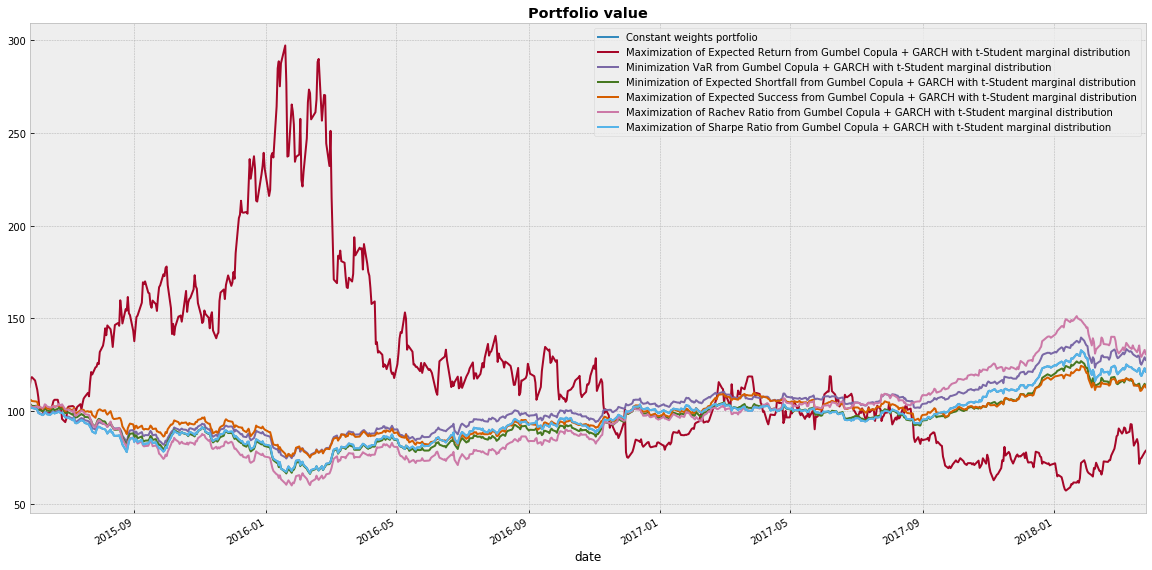

In [365]:
fig = plt.figure()
fig.set_size_inches(20,10)
value_const_weights.plot()
value_opt_weights_return.plot()
value_opt_weights_var.plot()
value_opt_weights_exp_shortfall.plot()
value_opt_weights_exp_success.plot()
value_opt_weights_rachev.plot()
value_opt_weights_sharpe.plot()

plt.title("Portfolio value", weight="bold")

plt.legend(['Constant weights portfolio',
            'Maximization of Expected Return from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Minimization VaR from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Minimization of Expected Shortfall from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Maximization of Expected Success from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Maximization of Rachev Ratio from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Maximization of Sharpe Ratio from Gumbel Copula + GARCH with t-Student marginal distribution'
           ])

#### Высокая амплитуда колебаний и низкая подстраиваемость под изменения  тренде курсов акций еще сильнее проявляется для максимизации ожидаемой доходности.
#### Здесь наилучший результат по прежнему показывает минимизация VAR и максимизация Sharpe Ratio

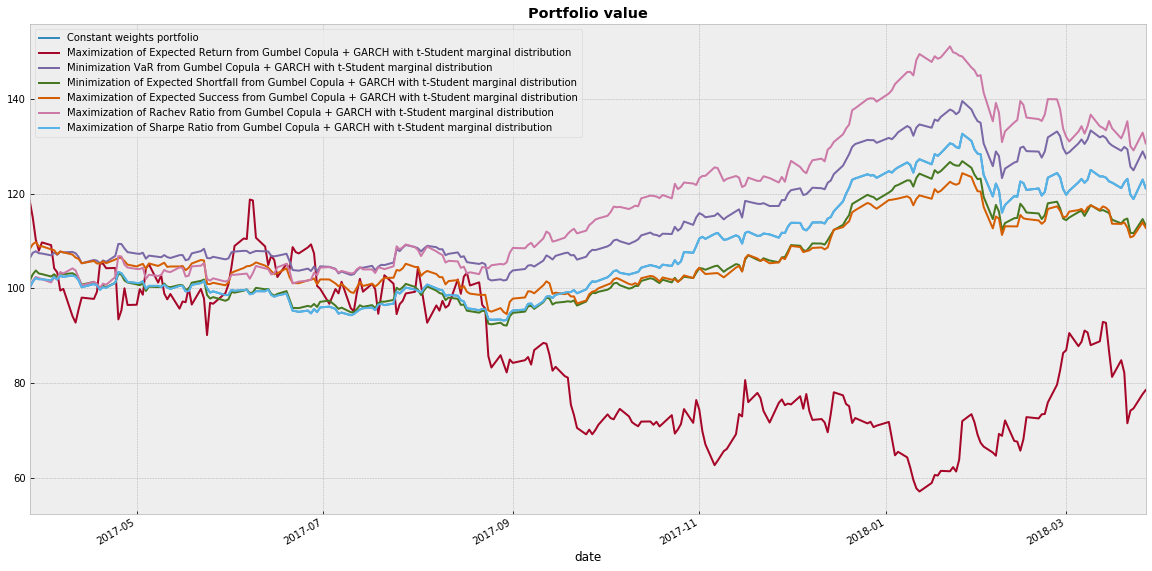

In [366]:
fig = plt.figure()
fig.set_size_inches(20,10)
value_const_weights['2017.03.27':'2018.03.27'].plot()
(value_opt_weights_return['2017.03.27':'2018.03.27']).plot()
value_opt_weights_var['2017.03.27':'2018.03.27'].plot()
value_opt_weights_exp_shortfall['2017.03.27':'2018.03.27'].plot()
value_opt_weights_exp_success['2017.03.27':'2018.03.27'].plot()
value_opt_weights_rachev['2017.03.27':'2018.03.27'].plot()
value_opt_weights_sharpe['2017.03.27':'2018.03.27'].plot()

plt.title("Portfolio value", weight="bold")

plt.legend(['Constant weights portfolio',
            'Maximization of Expected Return from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Minimization VaR from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Minimization of Expected Shortfall from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Maximization of Expected Success from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Maximization of Rachev Ratio from Gumbel Copula + GARCH with t-Student marginal distribution',
            'Maximization of Sharpe Ratio from Gumbel Copula + GARCH with t-Student marginal distribution'
           ])

#### В конце рассматриваемого периода максимизация ожидаемой доходности значительно проигрывает остальным моделям оптимизации весов портфеля.
#### Поскольку в целом стоимость акций на рассматриваемом промежутке росла, большинство методов оптимизации весов показывают схожие результаты.
#### Заметно также, что Rachev Ration вцелом более чувствителен к восходящему тренду, показывая наилучшие результаты. при этом, в периоды высокой волатильности и общего спада на рынке, данная метрика хуже подстраивается под изменения стоимости акций, показывая значительные провалы.
#### Доходность портфеля при оптимизации Sharpe Ratio сравнима с доходностью при оптимизации весов с использованием минимизации Expected Shortfall